# Library imported

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import torchvision
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torch.optim as optim

import torch.nn.functional as F

import colorama
from colorama import Fore, Style

from torchsummary import summary

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset analyzing

In [3]:
dataset_path = "/kaggle/input/garbage-classification-v2"

# Analyze dataset structure to understand what files are available
def analyze_dataset(root_dir):
    structure = {}
    for root, dirs, files in os.walk(root_dir):
        rel_dir = os.path.relpath(root, root_dir)
        if rel_dir == '.':
            continue
            
        # Count files by extension
        file_counts = {}
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext in file_counts:
                file_counts[ext] += 1
            else:
                file_counts[ext] = 1
                
        structure[rel_dir] = file_counts
        
    return structure

dataset_structure = analyze_dataset(dataset_path)
print("Dataset structure:")
for dir_path, file_types in dataset_structure.items():
    print(f"{dir_path}: {file_types}")

Dataset structure:
metal: {'.jpg': 1072, '.png': 4}
glass: {'.jpg': 3191, '.png': 7}
biological: {'.jpg': 997}
paper: {'.jpg': 1785, '.png': 2}
battery: {'.jpg': 944}
trash: {'.jpg': 950, '.png': 8, '.jpeg': 1}
cardboard: {'.jpg': 1851, '.png': 1}
shoes: {'.jpg': 1977}
clothes: {'.jpg': 5326, '.png': 1}
plastic: {'.png': 8, '.jpg': 2087}


# Data Loading and Preprocessing

In [4]:
dataset_path= "/kaggle/input/garbage-classification-v2"
dataset = datasets.ImageFolder(dataset_path)
len(dataset)

20212

In [5]:
garbage_class = dataset.classes
garbage_class

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [6]:
def load_image_paths(dataset_path):
    """Load image paths with corresponding labels from the dataset structure"""
    image_paths = []
    labels = []
    
    # Dictionary to map class folders to numeric labels
    class_map = {
        
         'battery' :0,
         'biological':1,
         'cardboard':2,
         'clothes':3,
         'glass':4,
         'metal':5,
         'paper':6,
         'plastic':7,
         'shoes':8,
         'trash': 9
        
    }
    
    # Iterate through each class folder
    for class_name, label in class_map.items():
        # Get all PNG images within this class
        png_path = os.path.join(dataset_path, class_name)
        
        if os.path.exists(png_path):
            png_files = glob.glob(os.path.join(png_path, '*.jpg'))
            
            # Add each image path with its label
            for img_path in png_files:
                image_paths.append(img_path)
                labels.append(label)
        else:
            print(f"Warning: Path {png_path} does not exist")
    
    return image_paths, labels

In [7]:
# Get image paths and labels
image_paths, labels = load_image_paths(dataset_path)

print(f"Found {len(image_paths)} images across {len(set(labels))} classes")


label_counts = pd.Series(labels).value_counts().sort_index()
print("Class distribution:")
for i, count in enumerate(label_counts):
    print(f"{garbage_class[i]}: {count} images")

Found 20180 images across 10 classes
Class distribution:
battery: 944 images
biological: 997 images
cardboard: 1851 images
clothes: 5326 images
glass: 3191 images
metal: 1072 images
paper: 1785 images
plastic: 2087 images
shoes: 1977 images
trash: 950 images


# Visualize some sample images

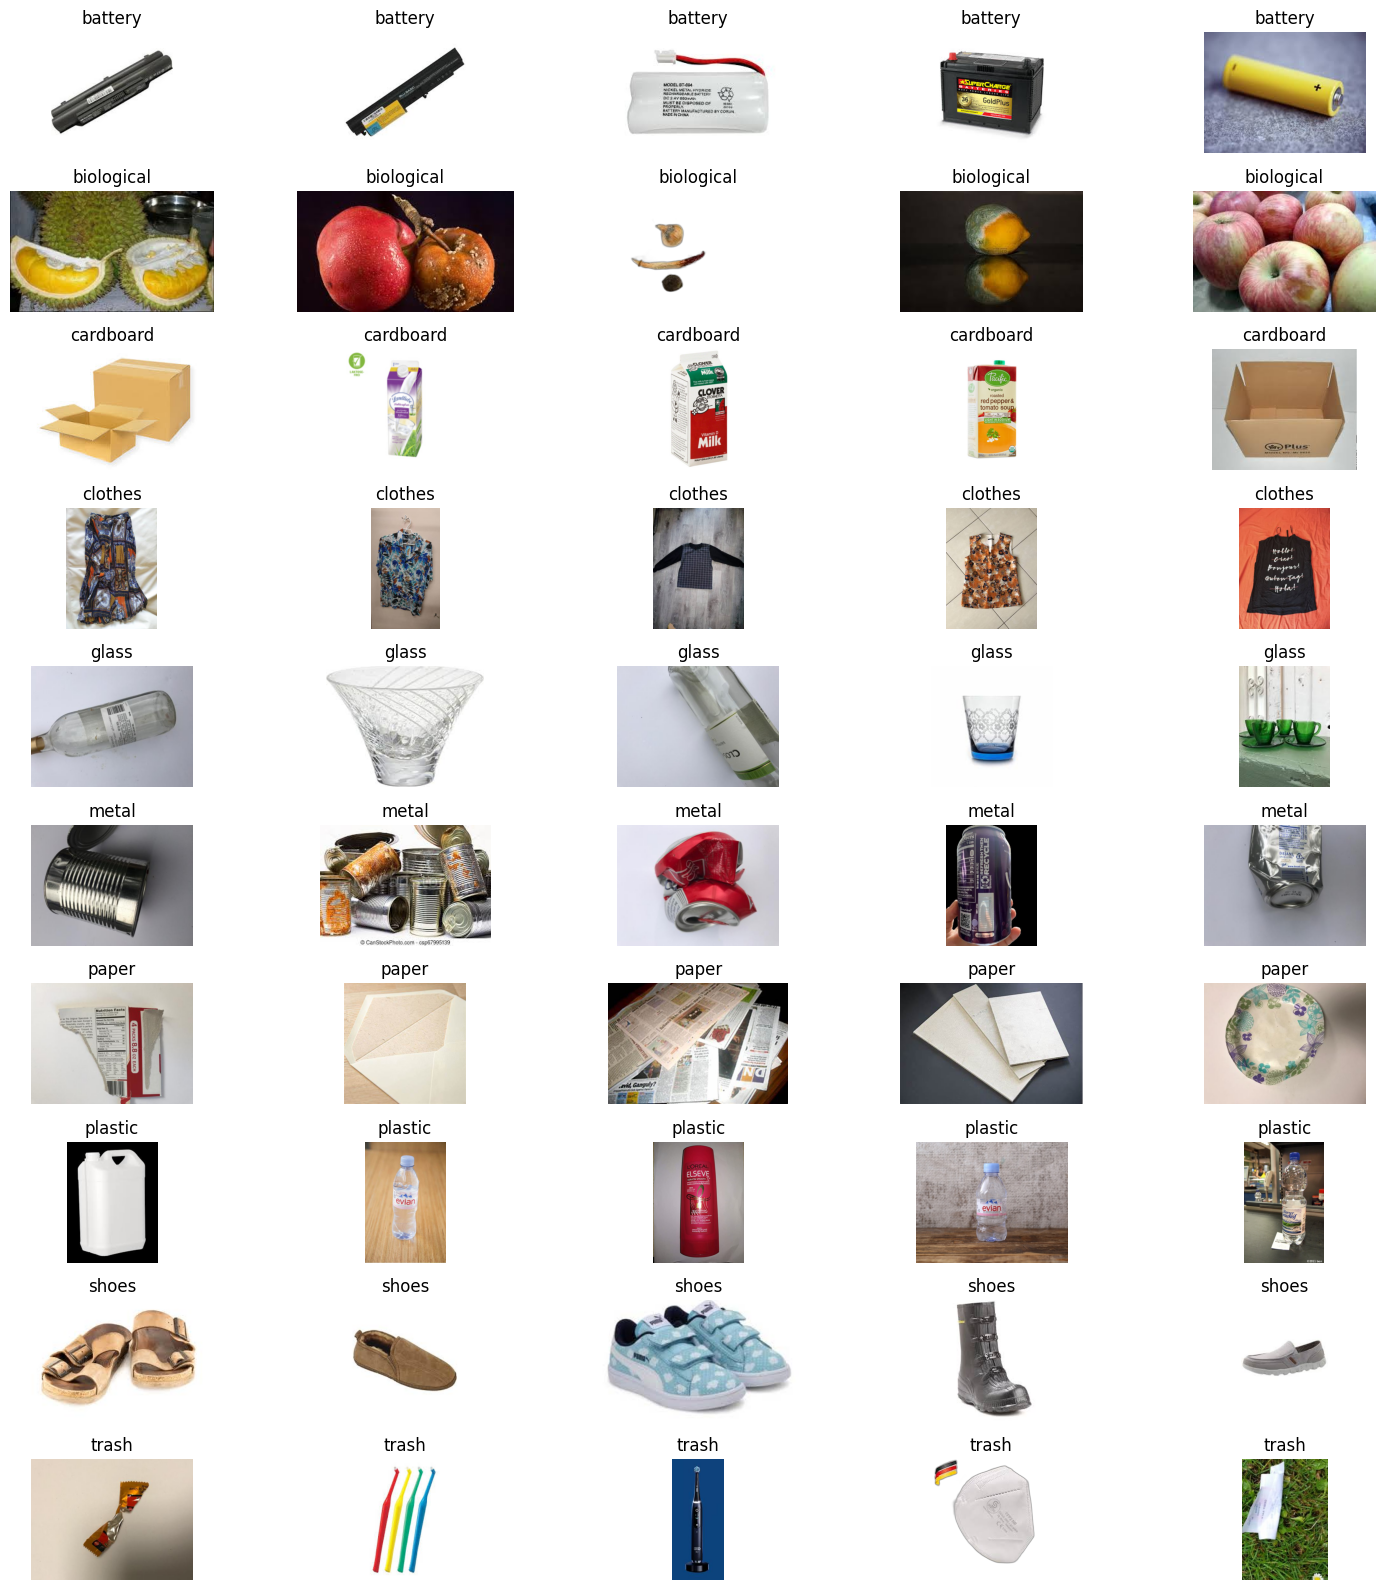

In [8]:
def show_samples(image_paths, labels, n_samples=5):
    # Get random indices for each class
    indices = {}
    for i in range(10):  # 10 classes
        class_indices = [idx for idx, label in enumerate(labels) if label == i]
        if len(class_indices) >= n_samples:
            indices[i] = np.random.choice(class_indices, n_samples, replace=False)
        else:
            indices[i] = class_indices
    
    # Create figure
    fig, axes = plt.subplots(10, n_samples, figsize=(15, 16))
    
    for i in range(10):  # For each class
        for j in range(min(n_samples, len(indices[i]))):  # For each sample
            idx = indices[i][j]
            img = Image.open(image_paths[idx])
            axes[i, j].imshow(img)
            axes[i, j].set_title(garbage_class[i])
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images
show_samples(image_paths, labels)

# Split into train and validation sets

In [9]:
# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Training set: 16144 images
Validation set: 4036 images


# Create a custom dataset

In [10]:
# Create a custom dataset class for brain CT images
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        else:
            # Basic conversion to tensor
            image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        
        # Get label
        label = self.labels[idx]
        
        return image, label

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the data to [-1, 1]
])

In [12]:
# Create datasets
train_dataset = FaceDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FaceDataset(val_paths, val_labels, transform=val_transform)

# Create data loaders
batch_size = 48
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check a batch of data
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([48, 3, 256, 256])
Labels shape: torch.Size([48])


In [13]:
garbage_classes = dataset.classes
garbage_classes

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

# MOdel train function define

In [14]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in tqdm(enumerate(train_loader)):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 200 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.4f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.4f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

# Resnet50 model loaded

In [15]:
import torch.nn as nn
import torchvision.models as models

class garbage_Model(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
            #nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Create model
model = garbage_Model(num_classes=10).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel created!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 244MB/s]



Model created!
Total parameters: 24,035,146
Trainable parameters: 15,491,850


# Model training

In [16]:
import torchvision.models as models
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=30)

201it [00:53,  3.68it/s]

Batch: 200, Epoch: 1, Loss: 0.2428


337it [01:28,  3.83it/s]


Epoch [1/30], Avg Loss: 0.3931


100%|██████████| 85/85 [00:22<00:00,  3.71it/s]

*** Validation Accuracy: 93.9049% ***



200it [00:44,  4.23it/s]

Batch: 200, Epoch: 2, Loss: 0.0902


337it [01:15,  4.47it/s]


Epoch [2/30], Avg Loss: 0.1882


100%|██████████| 85/85 [00:20<00:00,  4.24it/s]

*** Validation Accuracy: 94.5243% ***



200it [00:44,  4.65it/s]

Batch: 200, Epoch: 3, Loss: 0.0792


337it [01:12,  4.62it/s]


Epoch [3/30], Avg Loss: 0.1397


100%|██████████| 85/85 [00:16<00:00,  5.17it/s]

*** Validation Accuracy: 95.6888% ***



200it [00:40,  4.06it/s]

Batch: 200, Epoch: 4, Loss: 0.0511


337it [01:08,  4.91it/s]


Epoch [4/30], Avg Loss: 0.0986


100%|██████████| 85/85 [00:15<00:00,  5.36it/s]

*** Validation Accuracy: 95.8622% ***



200it [00:39,  5.28it/s]

Batch: 200, Epoch: 5, Loss: 0.0320


337it [01:06,  5.07it/s]


Epoch [5/30], Avg Loss: 0.0853


100%|██████████| 85/85 [00:16<00:00,  5.13it/s]

*** Validation Accuracy: 96.0852% ***



201it [00:40,  5.40it/s]

Batch: 200, Epoch: 6, Loss: 0.0980


337it [01:09,  4.86it/s]


Epoch [6/30], Avg Loss: 0.0787


100%|██████████| 85/85 [00:16<00:00,  5.20it/s]

*** Validation Accuracy: 94.9950% ***



200it [00:42,  4.28it/s]

Batch: 200, Epoch: 7, Loss: 0.0274


337it [01:08,  4.89it/s]


Epoch [7/30], Avg Loss: 0.0597


100%|██████████| 85/85 [00:16<00:00,  5.05it/s]

*** Validation Accuracy: 96.1348% ***



200it [00:41,  5.01it/s]

Batch: 200, Epoch: 8, Loss: 0.0375


337it [01:14,  4.52it/s]


Epoch [8/30], Avg Loss: 0.0565


100%|██████████| 85/85 [00:18<00:00,  4.70it/s]

*** Validation Accuracy: 95.3171% ***



200it [00:41,  5.31it/s]

Batch: 200, Epoch: 9, Loss: 0.0026


337it [01:09,  4.82it/s]


Epoch [9/30], Avg Loss: 0.0486


100%|██████████| 85/85 [00:17<00:00,  4.92it/s]

*** Validation Accuracy: 96.0605% ***



201it [00:42,  5.05it/s]

Batch: 200, Epoch: 10, Loss: 0.1110


337it [01:10,  4.78it/s]


Epoch [10/30], Avg Loss: 0.0516


100%|██████████| 85/85 [00:18<00:00,  4.71it/s]

*** Validation Accuracy: 95.9366% ***



200it [00:44,  4.76it/s]

Batch: 200, Epoch: 11, Loss: 0.0119


337it [01:14,  4.54it/s]


Epoch [11/30], Avg Loss: 0.0411


100%|██████████| 85/85 [00:18<00:00,  4.65it/s]

*** Validation Accuracy: 95.6888% ***



200it [00:45,  5.13it/s]

Batch: 200, Epoch: 12, Loss: 0.0101


337it [01:15,  4.49it/s]


Epoch [12/30], Avg Loss: 0.0378


100%|██████████| 85/85 [00:18<00:00,  4.69it/s]

*** Validation Accuracy: 96.3330% ***



201it [00:45,  3.98it/s]

Batch: 200, Epoch: 13, Loss: 0.0119


337it [01:17,  4.35it/s]


Epoch [13/30], Avg Loss: 0.0378


100%|██████████| 85/85 [00:17<00:00,  4.89it/s]

*** Validation Accuracy: 95.8870% ***



200it [00:43,  5.21it/s]

Batch: 200, Epoch: 14, Loss: 0.0847


337it [01:09,  4.85it/s]


Epoch [14/30], Avg Loss: 0.0349


100%|██████████| 85/85 [00:16<00:00,  5.24it/s]

*** Validation Accuracy: 96.3082% ***



200it [00:40,  5.57it/s]

Batch: 200, Epoch: 15, Loss: 0.0051


337it [01:07,  4.98it/s]


Epoch [15/30], Avg Loss: 0.0308


100%|██████████| 85/85 [00:17<00:00,  4.87it/s]

*** Validation Accuracy: 96.3578% ***



201it [00:40,  4.69it/s]

Batch: 200, Epoch: 16, Loss: 0.0032


337it [01:08,  4.94it/s]


Epoch [16/30], Avg Loss: 0.0336


100%|██████████| 85/85 [00:17<00:00,  4.79it/s]

*** Validation Accuracy: 95.9118% ***



201it [00:39,  5.65it/s]

Batch: 200, Epoch: 17, Loss: 0.0020


337it [01:05,  5.13it/s]


Epoch [17/30], Avg Loss: 0.0352


100%|██████████| 85/85 [00:16<00:00,  5.21it/s]

*** Validation Accuracy: 96.6303% ***



200it [00:42,  5.27it/s]

Batch: 200, Epoch: 18, Loss: 0.0795


337it [01:10,  4.79it/s]


Epoch [18/30], Avg Loss: 0.0302


100%|██████████| 85/85 [00:16<00:00,  5.12it/s]

*** Validation Accuracy: 96.6303% ***



201it [00:41,  5.49it/s]

Batch: 200, Epoch: 19, Loss: 0.0818


337it [01:09,  4.86it/s]


Epoch [19/30], Avg Loss: 0.0285


100%|██████████| 85/85 [00:17<00:00,  4.96it/s]

*** Validation Accuracy: 96.2339% ***



200it [00:40,  6.39it/s]

Batch: 200, Epoch: 20, Loss: 0.0247


337it [01:08,  4.94it/s]


Epoch [20/30], Avg Loss: 0.0248


100%|██████████| 85/85 [00:16<00:00,  5.16it/s]

*** Validation Accuracy: 96.1100% ***



201it [00:39,  5.95it/s]

Batch: 200, Epoch: 21, Loss: 0.0013


337it [01:06,  5.08it/s]


Epoch [21/30], Avg Loss: 0.0228


100%|██████████| 85/85 [00:16<00:00,  5.24it/s]

*** Validation Accuracy: 95.4163% ***



201it [00:40,  4.78it/s]

Batch: 200, Epoch: 22, Loss: 0.0922


337it [01:06,  5.08it/s]


Epoch [22/30], Avg Loss: 0.0342


100%|██████████| 85/85 [00:16<00:00,  5.21it/s]

*** Validation Accuracy: 95.7384% ***



200it [00:41,  5.56it/s]

Batch: 200, Epoch: 23, Loss: 0.0012


337it [01:08,  4.91it/s]


Epoch [23/30], Avg Loss: 0.0236


100%|██████████| 85/85 [00:15<00:00,  5.35it/s]

*** Validation Accuracy: 95.6888% ***



200it [00:38,  4.87it/s]

Batch: 200, Epoch: 24, Loss: 0.0022


337it [01:05,  5.15it/s]


Epoch [24/30], Avg Loss: 0.0243


100%|██████████| 85/85 [00:16<00:00,  5.31it/s]

*** Validation Accuracy: 96.2091% ***



200it [00:40,  5.40it/s]

Batch: 200, Epoch: 25, Loss: 0.0107


337it [01:07,  4.97it/s]


Epoch [25/30], Avg Loss: 0.0270


100%|██████████| 85/85 [00:16<00:00,  5.12it/s]

*** Validation Accuracy: 96.5064% ***



200it [00:39,  5.29it/s]

Batch: 200, Epoch: 26, Loss: 0.0160


337it [01:05,  5.11it/s]


Epoch [26/30], Avg Loss: 0.0232


100%|██████████| 85/85 [00:16<00:00,  5.08it/s]

*** Validation Accuracy: 96.0109% ***



201it [00:39,  6.07it/s]

Batch: 200, Epoch: 27, Loss: 0.0006


337it [01:05,  5.12it/s]


Epoch [27/30], Avg Loss: 0.0255


100%|██████████| 85/85 [00:16<00:00,  5.21it/s]

*** Validation Accuracy: 96.1843% ***



201it [00:39,  5.49it/s]

Batch: 200, Epoch: 28, Loss: 0.0038


337it [01:07,  5.01it/s]


Epoch [28/30], Avg Loss: 0.0173


100%|██████████| 85/85 [00:17<00:00,  4.99it/s]

*** Validation Accuracy: 96.4569% ***



200it [00:41,  5.51it/s]

Batch: 200, Epoch: 29, Loss: 0.0002


337it [01:08,  4.89it/s]


Epoch [29/30], Avg Loss: 0.0233


100%|██████████| 85/85 [00:16<00:00,  5.23it/s]

*** Validation Accuracy: 96.7542% ***



200it [00:38,  5.74it/s]

Batch: 200, Epoch: 30, Loss: 0.0207


337it [01:07,  5.02it/s]


Epoch [30/30], Avg Loss: 0.0225


100%|██████████| 85/85 [00:19<00:00,  4.43it/s]

*** Validation Accuracy: 96.0357% ***
Execution time: 2618.428399324417 seconds


# classification_report after trained

In [17]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       189
           1       0.99      0.95      0.97       200
           2       0.97      0.94      0.95       370
           3       1.00      0.99      0.99      1065
           4       0.97      0.96      0.97       638
           5       0.82      0.98      0.89       214
           6       0.94      0.95      0.95       357
           7       0.97      0.89      0.93       417
           8       0.95      0.99      0.97       396
           9       0.90      0.95      0.92       190

    accuracy                           0.96      4036
   macro avg       0.95      0.96      0.95      4036
weighted avg       0.96      0.96      0.96      4036



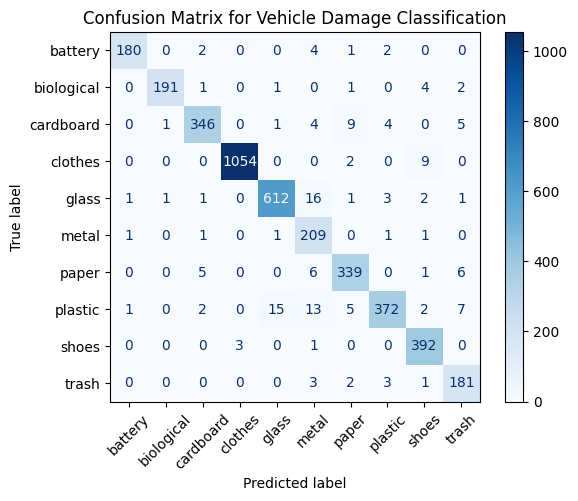

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(len(garbage_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=garbage_classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [19]:
torch.save(model.state_dict(), 'renset50_model.pth')

# Test the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


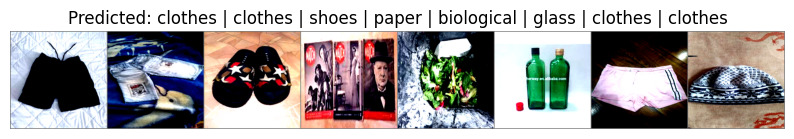

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


# Helper function to unnormalize and show an image
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize (if normalized to mean=0.5, std=0.5)
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()



# Get some test images.............................................
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


# Move model to eval mode and disable gradient tracking
model.eval()
with torch.no_grad():
    images = images
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)


# Move tensors to CPU for visualization
images = images.cpu()
predicted = predicted.cpu()

# Show images with predicted labels (first 8)
imshow(torchvision.utils.make_grid(images[:8]),
       title='Predicted: ' + ' | '.join(garbage_classes[pred] for pred in predicted[:8]))